# Aula: Rede Neural do 0 aplicada a reconhecimento de imagens MNIST (números e letras à mão)

### Requirements:

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

#### Torch + cuda:

pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

### Definindo a conversão de imagens para tensores

In [2]:
transform = transforms.ToTensor() # Define a conversão de imagens para tensores

trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform) # Carrega a parte de treino do datasset
trainloader = torch.utils.data.DataLoader(trainset,batch_size=64,shuffle=True) #Cria um buffer para pegar os dados por partes

valset = datasets.MNIST('./MNIST_data/',download=True,train=False,transform=transform) #Carrega a parte de validação do datasset
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True) # Cria um buffer para pegar os dados por partes

#### Resultado:

Cria pasta "MNIST_data", que contém os dados de treino e de validação importadas da lib de datassets do tochvision

- DIO

    |
    - MNIS_data

        |
        - MNIST

            |
            - Raw

### Verificar se a leitura da base de dados está correta:

A função ```iter()``` em Python retorna um iterador para um objeto. Em Python, um iterador é um objeto que implementa os métodos ```__iter__()``` e ```__next__()```. O método ```__iter__()``` retorna o próprio objeto iterador, enquanto o método ```__next__()``` retorna o próximo elemento da sequência, ou levanta a exceção StopIteration se não houver mais elementos para serem retornados.

No contexto do PyTorch e da classe DataLoader, a função ```iter()``` é frequentemente usada para criar um iterador a partir do DataLoader para iterar sobre os dados em batches. A iteração através do iterador é feita geralmente em um loop ```for```.

Após isso é realizada uma iteração em cima desses dados iterados para extrair uma imagem e uma etiqueta dessa lista de imagens e logo em seguida utilizada a função ```imshow``` do ```matplotlib``` para mostrar uma visualização desses dados numéricos, o que mostra a imagem original.

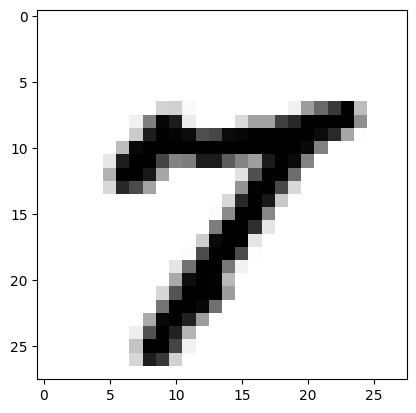

In [3]:
dataiter = iter(trainloader)

for bach in dataiter:
    imagens, etiquetas = bach

plt.imshow(imagens[0].numpy().squeeze(),cmap='gray_r')

#### Verificar tamanho do tensor que representa as imagens:

In [4]:
print(imagens[0].shape) # Verificar as dimensões do tensor de cada imagem
print(etiquetas[0].shape) # Verificar as dimensões do tensor de cada etiqueta

torch.Size([1, 28, 28])
torch.Size([])


#### Implementando uma rede neural inceptionV3 no processo de reconhecimento do datasset até então carregado

https://keras.io/api/applications/inceptionv3/

In [5]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo,self).__init__()
        self.linear1 = nn.Linear(28*28,128) # Camada de entrada, 748 neurônios se ligam á 128
        self.linear2 = nn.Linear(128,64) #camada interna 1, 128 neurônios se ligam á 24
        self.linear3 = nn.Linear(64,10) #camada interna 2, 64 neurônios se ligam á 10
        # para a camada de saída não é necessária definir nada pois só precisamos pegar a saída da camada interna 2

    def forward(self,X):
        X = F.relu(self.linear1(X)) # Função de ativação da camada de entrada para camada interna 1
        X = F.relu(self.linear2(X)) # Função de ativação da camada interna 1 para camada interna 2
        X = self.linear3(X) # Função de ativação da camada interna 2 para camada de saída, nesse caso f(x) = x
        return F.log_softmax(X,dim=1) # Dados utilizados para calcular a perda

#### Treinamento:

_19:33_

In [6]:
def treino(modelo,trainloader,device):
    otimizador = optim.SGD(modelo.parameters(),lr=0.01,momentum=0.5) # define a politica de atualização dos pesos e das bias
    inicio = time() # timer incial para sabermos quanto tempo levou o treino

    criterio = nn.NLLLoss() # definindo o critério para calcular a perda
    EPOCHS = 10 # numero de epochs que o algorítmo rodará
    modelo.train() # ativando o modelo de treinamento

    for epoch in range(EPOCHS):
        perda_acumulada = 0  # inicialização da perda acumulada da epoch em questão

        for imagens, etiquetas in trainloader:
            
            imagens = imagens.view(imagens.shape[0],-1) # convertento imagens para vetores de 28*28 casas
            otimizador.zero_grad() # zerando os gradientes por conta do ciclo anterior

            output = modelo(imagens.to(device)) # colocando os dados no modelo
            perda_instantanea = criterio(output,etiquetas.to(device)) # calculando a perda da epoch em questão

            perda_instantanea.backward() #back propagration a partir da perda

            otimizador.step() # atualizando os pesos e bias

            perda_acumulada += perda_instantanea.item() # atualização da perda acumulada

        else:
            print("EPOCH {} - Perda resultante: {}".format(epoch+1,perda_acumulada/len(trainloader)))
        print("\nTempo de treino em minutos = ",(time()-inicio)/60)


#### Validação:

In [7]:
modelo = Modelo()
device =torch.device("cuda" if torch.cuda.is_available() else "cpu") #redireciona o modelo se for GPU NVIDIA
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)